# Steganography by Vincent Gao

In [1]:
#Packages
using Images
using TestImages
using FileIO

### What is steganography? 
In simple terms, steganography is hiding information in plain sight. Steganography can come in many different forms whether it be a message written in invisible ink or a message encoded in a picture. In both of these examples, no information is being encrypted. The information is there if you know where to look, and this is the main advantage of steganography. For most encrypted messages, it is clear that the message was encrypted. This brings attention to a secret message being sent, but with steganography, the point is to take away that attention. If no one knows a secret message exists, no one is going to look for a secret message.

### The Null Cipher
A very simple example of steganography is the null cipher. A null cipher is a bunch of useless characters that surround the message in a pattern. Take this sentence:
Ancient short elves create racecar-eating tigers. 
An odd sentence, but no one would suspect there to be a secret message hidden in there. However, if you take the first letter of each word in that sentence, you'll get *a secret*. It might be an obvious example, but here's a better example from Wikipedia:

*PRESIDENT'S EMBARGO RULING SHOULD HAVE IMMEDIATE NOTICE. GRAVE SITUATION AFFECTING INTERNATIONAL LAW. STATEMENT FORESHADOWS RUIN OF MANY NEUTRALS. YELLOW JOURNALS UNIFYING NATIONAL EXCITEMENT IMMENSELY.*

Doing the same method I did previously, you get:

*Pershing sails from N.Y. June I*

The provided example is from a message sent by a German in WWII. The above text seemed to convey a message with meaning and wasn't nonsense like the example I came up. Thus, no one would think to look for a secret message encoded in that text. However, once someone knew there was a message, it became trivially easy to decipher. This simple example sums up the strengths and weaknesses of encoding a message with steganography.

Source: https://en.wikipedia.org/wiki/Null_cipher#

### Least Significant Bit(LSB)-Steganography
In the digital age, people have gotten more clever about using steganography. One such example is least significant bit steganography for digital images. Before I explain what LSB is, below there are two pictures. One of them is clean and another has an encoded message inside. Can you tell which image is the clean one and which is the encoded one?

![](gray_test_img.jpg) ![](encoded_test_img.png)

Between these two images, you can shouldn't be able to find a difference at all with the naked eye. Although there are a quite a few pixels changed, the amount I have changed the pixels are a miniscule amount. Let's see why this works:

### RGB and Grayscale
For nearly every single image you see on a computer, those images are usually made up of three values: red, green and blue. Each value spans between 0 and 255, which allows one to make over 16.7 million different colors from adjusting those three values. This amount of finetuning is great, but it also means there are some colors are different RGB-wise, but look the same to the naked eye. Take for instance these two colors:

In [2]:
color_compare = [0.2;0.51;0.3;; 0.2; 0.5; 0.3]
colorview(RGB, color_compare)

From the code, you can clearly tell that the two colors are different. However, if you look at the two colors side-by-side, the human eye can't tell the tiny difference between those two colors. To make things a bit simpler, I'm going to introduce grayscale, which is similar to RGB. Instead of 3 different values, there is only one value in grayscale. It is still bound between 0-255 and can only show varying shades of gray. Even with one value, it has the same property I described above for RGB. Take these two grays for instance:

In [3]:
gray_compare = [0.5,0.51]
colorview(Gray, gray_compare)

### ASCII Chart
I'm sure the majority of people know what the ASCII chart is, but to those that don't, ASCII stands for American Standard Code for Information Interchange and it is a chart of encoded characters that is standard for any electronic communication. It was originally encoded to only have 7 bits or 128 different characters, but it since evolved to be 8 bits or 256 different characters in in most electronics. Here is a chart of common ASCII encodings I will be using throughout this presentation:

![](ASCII.jpg)

Source: http://sticksandstones.kstrom.com/appen.html

###  Quick Sidebar: Useful Functions 
Instead of using the integers from 0-255, JuliaImages represents the values of RGB and Grayscale by shrinking down the scale to be between 0-1. It is a special type called N0f8 ( **N**ormalized, with **0** integer bits and **8** **f**ractional bits). There are complicated reasons behind this change, but in simple terms, if you want to get the value of 1 in grayscale, you would type 0.004 $\approx$ 1/255. An easier way of doing this is using Julia's built-in-function called **reinterpret**. It reinterprets the given memory into a different type, allowing you to from N0f8 to Int16 or any other type. Here's a short example of that in action:

In [4]:
reinterpret(UInt8, N0f8(0.1))

0x1a

Another useful one is **bitstring**, which converts an integer into a bit string

In [5]:
bitstring(100)

"0000000000000000000000000000000000000000000000000000000001100100"

When encoding a message, I use **chop** to remove an x amount of characters from a string starting from the head and/or tail.

In [6]:
chop("Secret")

"Secre"

In [7]:
#By default, it always chops off the last character
chop("Secret", head = 1)

"ecre"

In [8]:
chop("Secret", tail = 0, head = 1)

"ecret"

The built-in-function **string** can also in handy when you want to make a string from different values

In [9]:
string("A", 5, true)

"A5true"

In [10]:
#Order Matters!
string(5, "A", true)

"5Atrue"

### Encoding a Message
Knowing these two things, the values of RGB and grayscale can be represented as unsigned 8 bit integers (UInt8 in Julia). Now, you can change the least significant bit (LSB) of each value of a pixel to encode a message using the ASCII representation. Changing the LSB of a pixel will change their color by 1/255 or less than 0.4%, which to the human eye, is unnoticeable. For example, if I want to get encode *a* in an image, I would first need to get the binary representation of *a*. This can be done with the built-in-function bitstring(). 

In [4]:
#Helper function that takes a bitstring and converts to N0f8
function bitstring_to_N0f8(bin)
    bin = round(parse(Int, bin, base=2)/255, digits=3)
end

bitstring_to_N0f8 (generic function with 1 method)

In [11]:
# You could just do this
msg = bitstring('a')

# But that gives us leading zeros we don't care about. Instead:
msg = bitstring(UInt8('a'))

"01100001"

In [12]:
#Creating an image with 8 pixels
img_clean = Gray.(rand(N0f8,1, 8))
chv_img_encode = channelview(img_clean)

1×8 reinterpret(reshape, N0f8, ::Array{Gray{N0f8},2}) with eltype N0f8:
 0.224  0.22  0.616  0.537  0.247  0.478  0.475  0.898

We only care about the first 8-bits instead of 32-bits because ASCII is usually encoded to have 8 bits. Once you get the binary representation, you find an image you want to encode it with and then loop through each pixel of the image. Since our message has bits, we need at least 8 pixels.

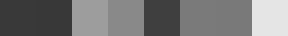

Gray{N0f8}[Gray{N0f8}(0.224) Gray{N0f8}(0.22) Gray{N0f8}(0.616) Gray{N0f8}(0.537) Gray{N0f8}(0.247) Gray{N0f8}(0.478) Gray{N0f8}(0.475) Gray{N0f8}(0.898)]


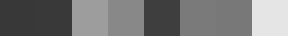

Gray{N0f8}[Gray{N0f8}(0.22) Gray{N0f8}(0.224) Gray{N0f8}(0.616) Gray{N0f8}(0.533) Gray{N0f8}(0.243) Gray{N0f8}(0.478) Gray{N0f8}(0.471) Gray{N0f8}(0.898)]


In [17]:
#Using LEAST significant bit
display(Gray.(img_clean))
println(Gray.(img_clean))
for i in 1:8
    to_change = bitstring(reinterpret(UInt8, chv_img_encode[1,i]))
    to_change = chop(to_change, tail = 1)
    to_change = string(to_change, msg[i])
    chv_img_encode[1,i] = bitstring_to_N0f8(to_change)
end
display(Gray.(chv_img_encode))
println(Gray.(chv_img_encode))

In [20]:
#Creating image wirh 8 pixels
bad_img_clean = Gray.(rand(N0f8,1, 8))
bad_chv_img_encode = channelview(bad_img_clean)

1×8 reinterpret(reshape, N0f8, ::Array{Gray{N0f8},2}) with eltype N0f8:
 0.004  0.035  0.345  0.427  0.106  0.118  0.455  0.541

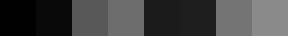

Gray{N0f8}[Gray{N0f8}(0.004) Gray{N0f8}(0.035) Gray{N0f8}(0.345) Gray{N0f8}(0.427) Gray{N0f8}(0.106) Gray{N0f8}(0.118) Gray{N0f8}(0.455) Gray{N0f8}(0.541)]


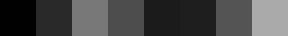

Gray{N0f8}[Gray{N0f8}(0.004) Gray{N0f8}(0.161) Gray{N0f8}(0.471) Gray{N0f8}(0.302) Gray{N0f8}(0.106) Gray{N0f8}(0.118) Gray{N0f8}(0.329) Gray{N0f8}(0.667)]


In [21]:
#Using the FOURTH LEAST signigicant bit to compare
display(Gray.(bad_img_clean))
println(Gray.(bad_img_clean))
for i in 1:8
    to_change = bitstring(reinterpret(UInt8, bad_chv_img_encode[1,i]))
    temp = to_change[4:8]
    to_change = chop(to_change, tail = 6)
    to_change = string(to_change, msg[i], temp)
    bad_chv_img_encode[1,i] = bitstring_to_N0f8(to_change)
end
display(Gray.(bad_chv_img_encode))
println(Gray.(bad_chv_img_encode))

Even with changing the fourth least significant bit, it is still hard to tell if there is any difference between the two images. However, looking at the values of each pixel, you can tell that differences between pixels are much larger in the pixels that do need to change their pixels.

### Participation Check
Right now, we can only use a bitstring() to convert a single character as the ASCII chart only has characters. Write a function that loops through each character in a string and returns a bitstring that has each character of that string in order. Each character should be represented in 8 bits. This is a helper function I have written below, but it's good practice to see the logic behind some of the helper functions.

In [0]:
#ANSWER HERE

### Decoding the Message
Now that we've encoded a message in an image, how do we extract that image. Since we know exactly how we encoded the message, it is easy to decrypt. By taking the least significant of each pixel, we can concatenate into a bitstring and then convert it into the corresponding ASCII character.

In [5]:
#Helper function that takes a bitstring and converts to its corresponding ASCII character
function bitstring_to_char(bin)
    bin = Char(parse(Int, bin, base = 2))
end

bitstring_to_char (generic function with 1 method)

In [34]:
message = ""
for i in 1:8
    bit = bitstring(reinterpret(UInt8, chv_img_encode[1,i]))[8]
    message = string(message, bit)
    if length(message) == 8
        message = bitstring_to_char(message)
    end
end
message

'a': ASCII/Unicode U+0061 (category Ll: Letter, lowercase)

Decoding a message is a simple as that if you know how it is encoded. Detecting steganography on the other hand is a whole other topic that is out of the scope of this presentation. For now, I will usually tell you how a message encoded.

### Let's Do It On An Actual Image
We've been doing LSB steganography on very impractical images, so let's try it on actual image. Here I have written an encoder that encodes the message of an image starting from the top-right corner pixel going down and once it hits the bottom, it shifts to the right and going down again, repeating until the message has been encoded.

This helper function, **bitstring_message()** takes in the secret message and converts the message into one long bitstring, character by character. Previously, we could only do one character long messages, since there is no ASCII representation for strings. With this function, each 8 bits of the string will be a character in our message.

In [9]:
function bitstring_message(msg)
    bit_msg = ""
    for i in 1:length(msg)
        bit_msg = bit_msg * bitstring(UInt8(msg[i]))
    end
     bit_msg
end

bitstring_message (generic function with 1 method)

In [6]:
function encoder(path, message)
    gImg = Gray.(load(path))
    height, width = size(gImg)
    chv = channelview(gImg)
    delim = bitstring_message(" delim")                        #Since a message isn't usually encoded in the full image, I add a delim to tell the decoder when to stop.
    bit_msg = bitstring_message(message)
    bit_msg = string(bit_msg, delim)
    count = 1
    if length(bit_msg) > height*width                          #This makes sure there are enough pixels to encode the message
        return error("Image too small")
    end
    widthTimes = ceil(length(bit_msg)/width)                   #This is for the outer for loop as a way to know when to break out of the outer for loop by knowing ahead of
    for i in 1:height                                          #time how many times it will shift
        for j in 1:width
            insert = bit_msg[count]
            count += 1
            change = bitstring(reinterpret(UInt8, chv[i,j]))
            change = chop(change)
            change = string(change, insert)
            chv[i,j] = bitstring_to_N0f8(change)
            if count >= length(bit_msg)                        #This breaks out of the inner for loop when the message has been encoded fully with the delim
                break
            end
        end
        if i > widthTimes
            break;
        end
    end
    Gray.(chv)
end

encoder (generic function with 1 method)

In [32]:
#Getting secret message
open("secret_msg.txt")
secret = read("secret_msg.txt", String);
length(secret)

2473

In [34]:
encoded = encoder("StartEnd.png", secret);

Source: https://twitter.com/MikaPikaZo/status/1637080848901238784

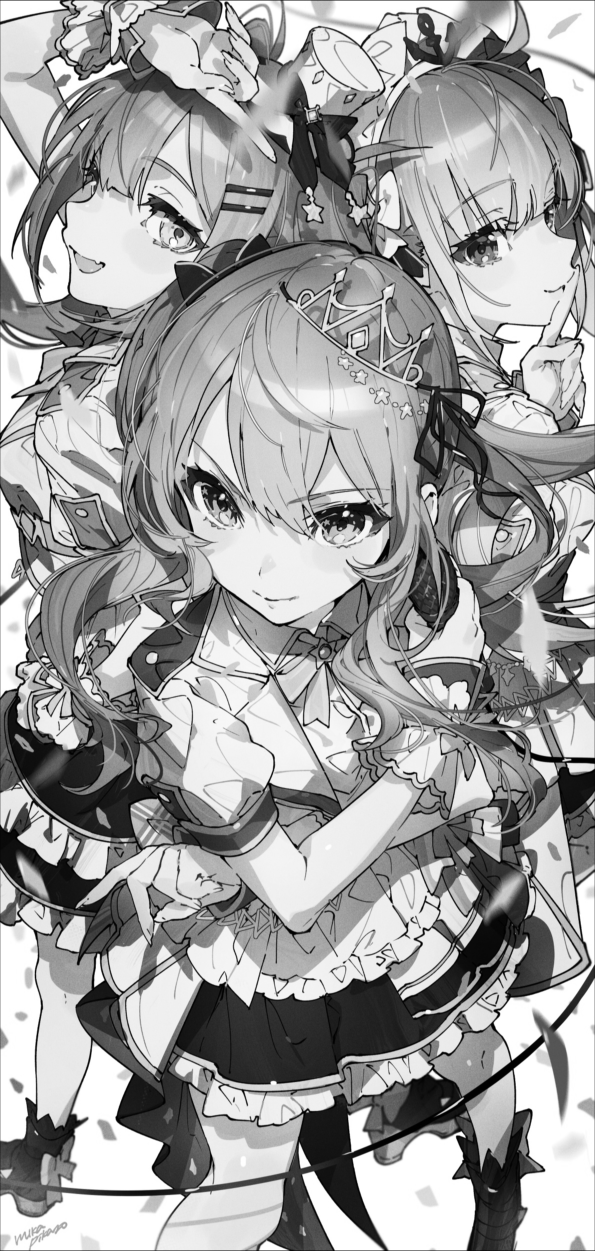

In [35]:
#Comparing the two images once again
original_gray = Gray.(load("StartEnd.png"))
display(original_gray)

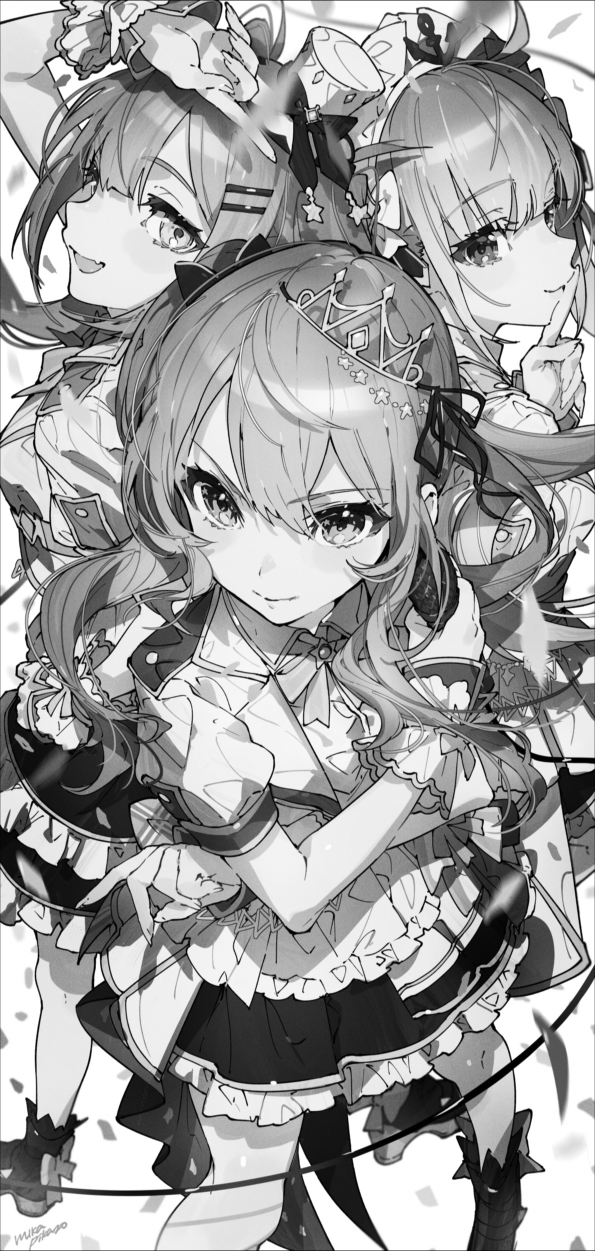

In [36]:
display(encoded)

To decode the message, we take the LSB of each pixel of the encoded picture and translate that back to the secret message. In this case, we started at the top-right corner pixel, going down to the bottom, shifting to the right by one pixel, and repeating. The decoding function will be left as a homework problem for you to solve.

### Ending Remarks
The one thing I have avoided mentionning is detecting LSB steganography. This topic could be its own presentation and isn't within the scope of this presentation. In brief, the most reliable way to detect steganography is by comparing the suspected image with the original image. Simply look for any differences between the two pictures pixel-wise and if there are, then you know a message is encoded in there. If you don't have the original image, you rely on statistical analysis, which again, is not in the scope of this presentation. 

# Thanks for taking the time to read/listen to my presentation!

# Homework Problems

### Question 1
1) We have encoded a file called "secret_msg.txt" into "StartEnd.jpg". Knowing how I encoded the file into the image, write a function that returns the message I encoded in the image. The encoded image has already been saved in the folder and it is called "StartEnd_encoded.png".

Extra: if you run the decoder on the "encoded_test_img.png" that is also in the folder and the plane image at the beginning of the lecture, there is also an image encoded in there :)

In [0]:
function decoder_hw(img)
    #ANSWER HERE

In [50]:
#Solution
function decoder(img)
    gImg = Gray.(img)
    height, width = size(gImg)
    chv = channelview(gImg)
    bit = 0;
    translate = ""
    message = ""
    for i in 1:height
        for j in 1:width
            bit = bitstring(reinterpret(UInt8, chv[i,j]))[8]
            translate = string(translate,bit)
            if length(translate) == 8
                message = string(message, bitstring_to_char(translate))
                translate = ""
            end
            if occursin("delim", message)
                break
            end
        end
        if occursin("delim", message)
            break
        end
    end
    message
end
StartEnd_msg = load("StartEnd_encoded.png")
plane_msg = load("encoded_test_img.png")
println(decoder(StartEnd_msg))
println(decoder(plane_msg))

According to all known laws of aviation, there is no way a bee should be able to fly. Its wings are too small to get its fat little body off the ground. The bee, of course, flies anyway because bees don't care what humans think is impossible. Yellow, black. Yellow, black. Yellow, black. Yellow, black. Ooh, black and yellow! Let's shake it up a little. Barry! Breakfast is ready! Coming! Hang on a second. Hello? - Barry? - Adam? - Can you believe this is happening? - I can't. I'll pick you up. Looking sharp. Use the stairs. Your father paid good money for those.  This runway is covered with the last pollen from the last flowers available anywhere on Earth. That means this is our last chance. We're the only ones who make honey, pollinate flowers and dress like this. If we're gonna survive as a species, this is our moment! What do you say? Are we going to be bees, or just Museum of Natural History keychains? We're bees! Keychain! Then follow me! Except Keychain. Hold on, Barry. Here. You'v

### Question 2
Let's look at some of the math behind LSB. In LSB Steganography, we replace the least significant bit, which is the right-most bit. A binary number is represented as a series of 1s and 0s. The easiest way to understand this is by looking at an example. Take the base-10 number 4 for instance.
$$1*2^2 + 0*2^1 + 0*2^0 = 4$$

Taking the coefficients of the powers of 2, we get:
$$100$$
which is the representation of 4 in binary in 3 bits. If we want it in 8 bits, we just add trailing zeros like this:
$$00000100$$

2a) Let's start with converting the base-10 number 100 into binary (base-2) using 8 bits.

In [51]:
#Solution
"01100100"

"01100100"

2b) What number in base-10 would you get if you flipped the LSB of your answer in 2a? Note: when I say flip a bit, you are going from 1 to 0 or 0 to 1, whichever one applies.

In [52]:
#Solution
"101"

"101"

2c) What if you flipped the fouth least significant bit?

In [53]:
#Solution
"108"

"108"

2d) What if you flipped the most significant bit or eight least significant bit?

In [54]:
#Solution
"228"

"228"

2e) Seeing the differences in flipping the nth least significant bit and knowing the values of RGB and grayscale are in 8 bits, what is the highest nth least significant bit you can flip if you tolerable with a less than 2% change to each pixel?

In [55]:
#Solution
# 8 bits means max of 255 Doing:
255*0.02
# we get 5.1. The two powers of 2 between 5.1 is 2^2 and 2^3. We want the bit less than 2%, so thus, it is the second least significant bit
"2nd least significant bit"

"2nd least significant bit"